In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output, display
import os
import random
import string
import pandas as pd
%matplotlib inline

In [8]:
EXPECTEDIMAGEWIDTH = 256

# Total dataset: 95,486

2    21713
3    21327
4    21492
5    21353
6    21467
7    21389
8    21076
a    21436
b    21145
c    21321
d    21096
e    21546
f    21396
g    21342
h    21293
k    21222
m    21151
n    21733
p    21134
r    21481
w    17112
x    16614
y    16591
Name: characters, dtype: int64

<AxesSubplot:title={'center':'Character Occurrance'}>

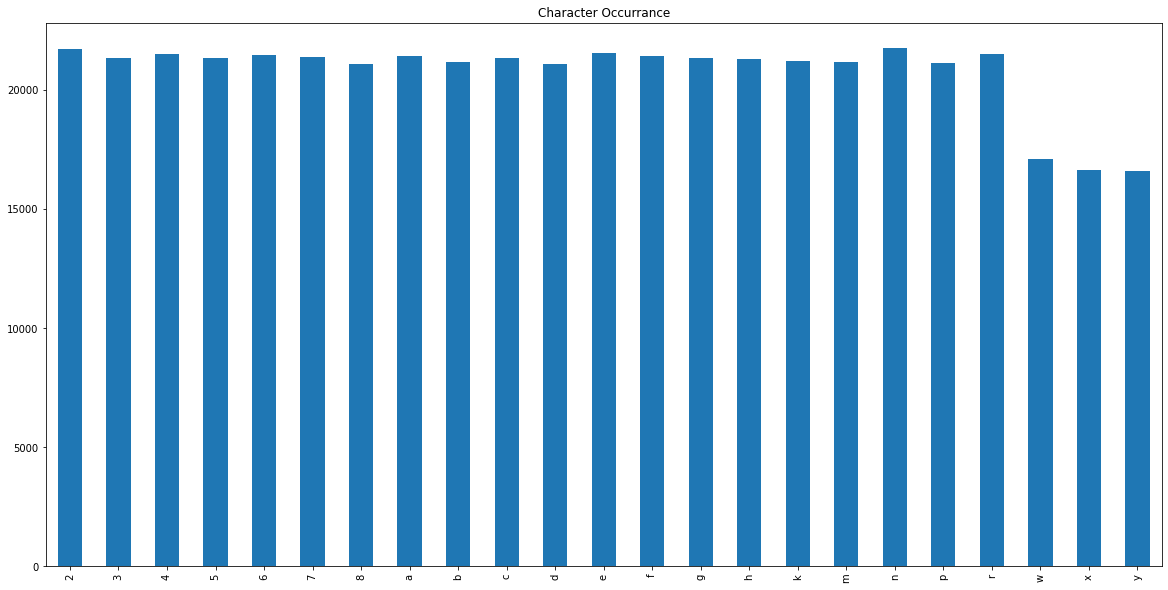

In [3]:
characterList = []
dataset_path = r"C:\Users\jaydu\Documents\Durham\CapstoneGroup5\AutoCaptcha\datasetImages\set6\captcha_images"
for root,dre, files in os.walk(dataset_path):
    for name in files:
        characterList.extend(list(name.replace(".png","")))
df = pd.DataFrame({"characters":characterList})
character_data = df.characters.value_counts().sort_index()
display(character_data)
character_data.plot.bar(title="Character Occurrance",figsize=(20,10))

In [ ]:
character_data.to_csv("character.csv")

In [5]:
character_data.shape

(23,)

### Note: Many character are avoided by major technologies like BotDetect, because they can be eaily confused for each other
### For example (0,o),(1,i,j), etc....
#### Hence out of the expected 36 characters only 23 characters are present

# Image Pre Processing includes 
## 1) Thresholding images such that pixels above 75 are converted to 0 to make lines darker
## 2) Dilating the image is done to eliminate the distortion line
## 3) Eroding brings back the pixel thicknes
## 4) Sharpening makes the edges easier
## 5) Binary thresholding does is a final step before image segmentation

In [24]:
class AutoCaptcha:
    kernel = np.ones((3, 3), np.uint8)
    def __init__(self, imagePath="", label = ""):
        try:
            # use the image object for your operations
            self.imageObject = cv2.imread(imagePath,cv2.IMREAD_UNCHANGED)
            #make mask of where the transparent bits are
            trans_mask = self.imageObject[:,:,3] == 0
            self.imageLabel = label
            #replace areas of transparency with white and not transparent
            self.imageObject[trans_mask] = [255, 255, 255, 255]

            #new image without alpha channel...
            self.imageObject = cv2.cvtColor(self.imageObject, cv2.COLOR_BGRA2BGR)
            # self.ImageShow()
            self.imageObject = cv2.cvtColor(self.imageObject, cv2.COLOR_BGR2GRAY)
        except Exception as e:
            logging.exception("Exception Image constructor", exc_info=True)
            print(e)
    
    def ImageThresholding(self,thresholdType,thresholdValue):
        try:
            ret,self.imageObject = cv2.threshold(self.imageObject,thresholdValue,255,thresholdType)
        except Exception as e:
            logging.exception("Exception Image constructor", exc_info=True)
            print(e)

    def ImageShow(self):
        try:
            plt.imshow(self.imageObject)
            plt.show()
            #cv2.imshow('image', self.imageObject)
            #cv2.waitKey(0)
        except Exception as e:
            logging.exception("Exception Image Show", exc_info=True)
            # print(e)
        finally:
            pass

    def ImageWrite(self, writePath):
        try:
            cv2.imwrite(writePath, self.imageObject)
        except Exception as e:
            logging.exception("Exception Image Show", exc_info=True)
            print(e)

    def GrayUpScale(self):
        try:
            pass
            # scaling the image to expected width
            oldHeight, oldWidth = self.imageObject.shape
            newWidth = EXPECTEDIMAGEWIDTH
            newHeight = int(newWidth * oldHeight / oldWidth)
            # reassigning the image with the gray scale version
            # self.imageObject = cv2.cvtColor(self.imageObject, cv2.COLOR_BGR2GRAY)
            # reassigning the image with the scaled version
            self.imageObject = cv2.resize(self.imageObject, (newWidth, newHeight))
        except Exception as e:
            logging.exception("Exception GrayUpScale", exc_info=True)
            print(e)

    def Erosion(self,iterations):
        try:
            self.imageObject = cv2.erode(self.imageObject, self.kernel, iterations=iterations)
            print("Post Erosion")
            #self.ImageShow()
        except Exception as e:
            logging.exception("Exception Erosion", exc_info=True)
            print(e)
    
    def Sharpening(self):
        try:
            sharpenFilter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
            self.imageObject = cv2.filter2D(self.imageObject, -1, sharpenFilter)
            #print("Post Sharpening")
            #self.ImageShow()
        except Exception as e:
            logging.exception("Exception Sharpening", exc_info=True)
            print(e)
    
    def test(self):
        img = self.imageObject
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(img,50,150,apertureSize = 3)
        minLineLength = 100
        maxLineGap = 10
        lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
        for x1,y1,x2,y2 in lines[0]:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.imwrite('houghlines5.jpg',img)

    def Dilation(self,iterations):
        try:          
            self.imageObject = cv2.dilate(self.imageObject, self.kernel, iterations=iterations)
            print("Post Dilation")
            self.ImageShow()            

            
        except Exception as e:
            logging.exception("Exception Dilation", exc_info=True)
            print(e)
    
    def MorphologicalGradient(self):
        try:
            self.imageObject = cv.morphologyEx(self.imageObject, cv.MORPH_GRADIENT, self.kernel)
        except Exception as e:
            logging.exception("Exception MorphologicalGradient", exc_info=True)
            print(e)
            
    def ImageSkeletonization(self):
        # Applying Zhang's thining algorithm on the image to eliminate distorting lines and pixels that are usual thinner than the character strokes
        self.imageObject = cv2.ximgproc.thinning(self.imageObject, cv2.ximgproc.THINNING_ZHANGSUEN)
    
    def CropImage(self):
        def parseStats(colStatus):
            st = 0
            ed = len(colStatus)-2
            # print(colStatus)
            while colStatus[st]:
                st += 1
            while colStatus[ed]:
                ed -= 1
            return [st - 1, ed + 1]
        height, width =  self.imageObject.shape
        emptyCols = parseStats((np.sum(self.imageObject,axis=0)/255) >= (0.90*height))
        emptyRows = parseStats((np.sum(self.imageObject,axis=1)/255) >= (0.90*width))
        self.imageObject = self.imageObject[emptyRows[0]:emptyRows[1],emptyCols[0]:emptyCols[1]]
        

    def CropToContour(self):
        """HSV = cv2.cvtColor(self.imageObject, cv2.COLOR_BGR2HSV)
        low = np.array([0, 35, 0])
        high = np.array([253, 255, 255])

        mask = cv2.inRange(HSV, low, high)
        cv2.imshow("mask", mask)

        result = cv2.bitwise_and(self.imageObject, self.imageObject, mask=mask)
        cv2.imshow("result", result)"""
        contours, heirarchy = cv2.findContours(~self.imageObject, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(self.imageObject, contours, 0, (0,255,0), 3)
        
        #sortedCountours = sorted(contours, key=cv2.contourArea)[-1]
        #x,y,w,h = cv2.boundingRect(sortedCountours)
        #cv2.drawContours(self.imageObject, contours, -1, (0, 255, 0), 3)
        #cv2.imshow('Contours', self.imageObject)
        #self.imageObject = self.imageObject[y:y+h, x:x+w]
        
    def Segmentation(self):
        try:
            height, width = self.imageObject.shape
            segWidth = width // len(self.imageLabel)
            s = 0
            for i in range(len(self.imageLabel)):
                fileLoc = r"C:\Users\jaydu\Documents\Durham\CapstoneGroup5\AutoCaptcha\characters\{}\{}.png".format(self.imageLabel[i],''.join(random.choices(string.ascii_uppercase + string.digits, k=7)))
                # cv2.imwrite(fileLoc,self.imageObject[:,s:s+segWidth])
                #plt.imshow(self.imageObject[:,s:s+segWidth])
                #plt.show()
                s = s+segWidth + 1
        except Exception as e:
            print(e)
        
    def preProcessing(self, wrt=""):
        print("Original Image")
        self.ImageShow()
        self.GrayUpScale()
        # self.CropToContour()
        print("Upscaled Image")
        self.ImageShow()
        
        
        #self.ImageThresholding(cv2.THRESH_BINARY, 100)
        #print("Post thresholding")
        #self.ImageShow()
        self.Dilation(iterations=4)
        #self.Erosion(1)
        self.Sharpening()        
        #self.Dilation(iterations=3)
        # self.CropToContour()
        #self.imageObject = cv2.medianBlur(self.imageObject,9)
        self.ImageThresholding(cv2.THRESH_BINARY, 152)
        self.CropImage()
        
        self.Segmentation()
        
        

Original Image


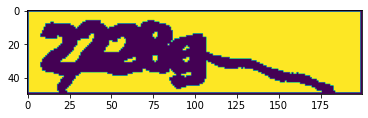

Upscaled Image


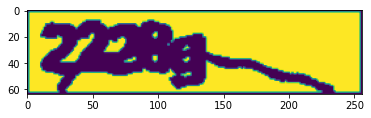

Post Dilation


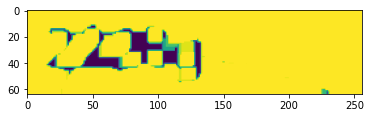

Original Image


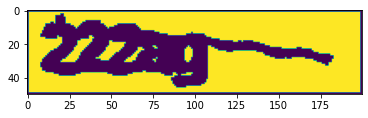

Upscaled Image


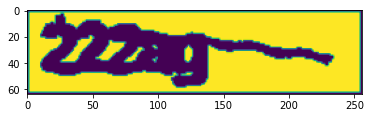

Post Dilation


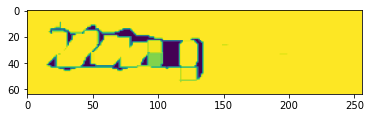

Original Image


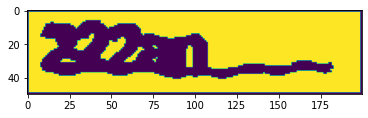

Upscaled Image


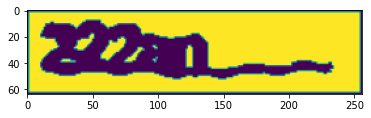

Post Dilation


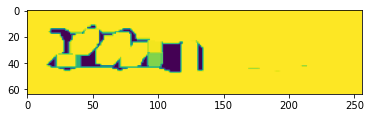

Original Image


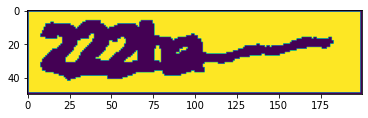

Upscaled Image


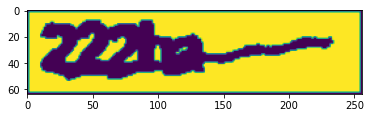

Post Dilation


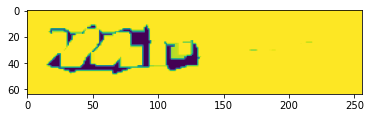

Original Image


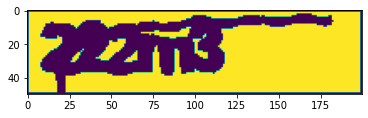

Upscaled Image


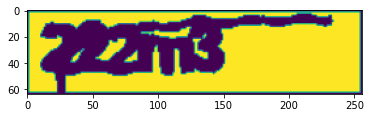

Post Dilation


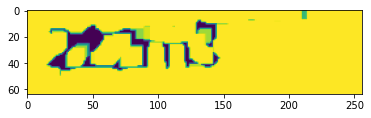

In [25]:
r = 0
for root, dirs, files in os.walk(r"C:\Users\jaydu\Documents\Durham\CapstoneGroup5\AutoCaptcha\datasetImages\set6\captcha_images"):
    for name in files:
        # print(os.path.join(root, name))
        imgOj = AutoCaptcha(os.path.join(root, name),name.replace(".png",""))
        imgOj.preProcessing()
        r+=1
        # clear_output()
        # int(int(r*100/95486))
        if r ==5:
            break
        #imgOj.ImageShow()
#print("Final")

#imgOj.ImageWrite(i.replace(r"\datasetImages\set1\captcha_images",""))
#print("------------------------------------------------------------------------------")
    

# Modelling

In [2]:
import tensorflow as tf

In [3]:
training_data = tf.keras.utils.image_dataset_from_directory(r"C:\Users\jaydu\Documents\Durham\CapstoneGroup5\AutoCaptcha\dataset\train", labels="inferred")

Found 241523 files belonging to 23 classes.


In [4]:
test_data = tf.keras.utils.image_dataset_from_directory(r"C:\Users\jaydu\Documents\Durham\CapstoneGroup5\AutoCaptcha\dataset\test", labels="inferred")

Found 103500 files belonging to 23 classes.


In [5]:
vaildation_data = tf.keras.utils.image_dataset_from_directory(r"C:\Users\jaydu\Documents\Durham\CapstoneGroup5\AutoCaptcha\dataset\validation", labels="inferred")

Found 124802 files belonging to 23 classes.


In [6]:
my_batch_size = 16
training_data.batch(my_batch_size)
test_data.batch(my_batch_size)
vaildation_data.batch(my_batch_size)

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (2, 2), activation='relu'))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128,"relu"))
#model.add(tf.keras.layers.Dense(64,"relu"))
model.add(tf.keras.layers.Dense(23, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 flatten (Flatten)           (None, 1016064)           0         
                                                                 
 dense (Dense)               (None, 128)               130056320 
                                                                 
 dense_1 (Dense)             (None, 23)                2967      
                                                        

In [9]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics=tf.keras.metrics.categorical_accuracy)

In [10]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath="./checkpoint_filepath", save_weights_only=True,
    monitor='categorical_accuracy', mode='max', save_best_only=True)

In [11]:
history = model.fit(training_data, steps_per_epoch=8,epochs=50,verbose=1,validation_data = vaildation_data,validation_steps=8,callbacks=[model_checkpoint_callback])

Epoch 1/50


C:\Users\jaydu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 23s 3s/step - loss: 6867.1836 - categorical_accuracy: 0.0000e+00 - val_loss: 2919.5259 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 11s 1s/step - loss: 1285.7236 - categorical_accuracy: 0.0000e+00 - val_loss: 129.4476 - val_categorical_accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 12s 1s/step - loss: 43.7994 - categorical_accuracy: 0.0000e+00 - val_loss: 19.3392 - val_categorical_accuracy: 0.0000e+00
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 10.8919 - categorical_accuracy: 0.0000e+00 - val_loss: 3.1738 - val_categorical_accuracy: 0.0039
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 3.5652 - categorical_accuracy: 0.0000e+00 - val_loss: 3.2593 - val_categorical_accuracy: 0.0156
Epoch 6/50
8/8 [==============================] - 11s 1s/step - loss: 3.1543 - categorical_accuracy: 0.0000e+00 - val_loss: 3.3550 - val_categorical_accura

In [13]:
model.evaluate(vaildation_data)

3901/3901 [==============================] - 787s 202ms/step - loss: 2.2818 - categorical_accuracy: 0.0522


[2.2817773818969727, 0.05220269039273262]

In [18]:
STEP_SIZE_TEST=25
preds = model.predict(vaildation_data, verbose=1)

3901/3901 [==============================] - 752s 193ms/step
